Brief description of the problem and data

The author uses the term “ABLAZE” metaphorically, which is easily understood by humans, especially with accompanying visuals. However, this metaphorical usage poses challenges for machine interpretation. In this competition, participants are tasked with developing a machine-learning model to distinguish between Tweets that discuss natural disasters and those that do not. The dataset provided for this competition includes over 10,000 tweets that have been labeled as either “disaster” or “not disaster” tweets. The data was collected using a variety of searches including keywords related to natural disasters and other data sources. Each tweet is labeled by human annotators who have been trained to label tweets. The dataset is provided by the company figure-eight and is available on the Kaggle platform. The dataset consists of the following columns:

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report,confusion_matrix

import datasets
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer,AutoModel,TrainingArguments
from transformers import AutoModelForSequenceClassification,AutoConfig
from transformers import Trainer,BertModel,BertForSequenceClassification
from transformers import DataCollatorWithPadding
import torch

Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [2]:
import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/train.csv
./data/sample_submission.csv


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# Read the train and test data and display the dataset
data_train = pd.read_csv('./data/train.csv')
data_test  = pd.read_csv('./data/test.csv')

# Rename the target column
data_train.rename(columns={'target':'labels'},inplace=True)

data_train.head() # Display the first 5 rows of the train dataset

,id,keyword,location,text,labels
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Dimension of the train and test datasets
data_train.shape, data_test.shape

((7613, 5), (3263, 4))

In [6]:
# Check for missing values in the train and test datasets
data_train.isnull().sum(), data_test.isnull().sum()

(id             0
 keyword       61
 location    2533
 text           0
 labels         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64)

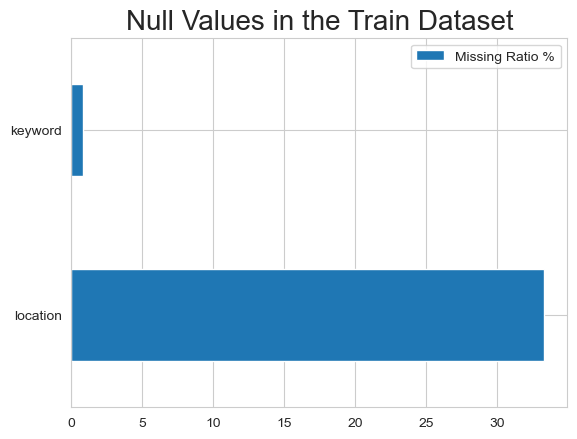

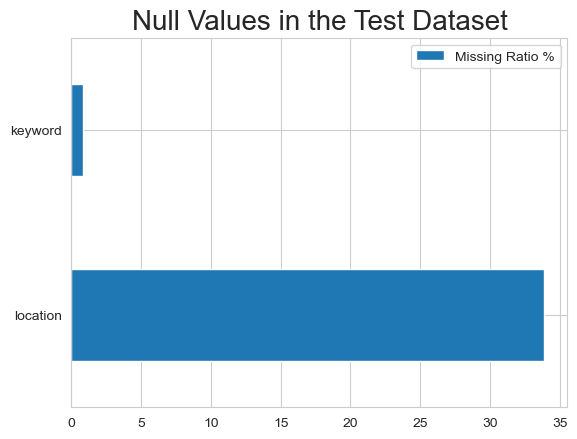

In [7]:
# Plot percentage of null values in the train and test datasets
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame, title):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.title(title,fontsize=20)
        plt.show()
    else:
        print('No NAs found')

plot_nas(data_train, "Null Values in the Train Dataset")
plot_nas(data_test, "Null Values in the Test Dataset")

In [8]:
# Duplicate values in train and test data
data_train.duplicated().sum(), data_test.duplicated().sum()

(0, 0)

In [9]:
# Shuffle the train data
data_train = data_train.sample(frac=1,random_state=42)
data_train.head()

,id,keyword,location,text,labels
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Text(0, 0.5, 'count')

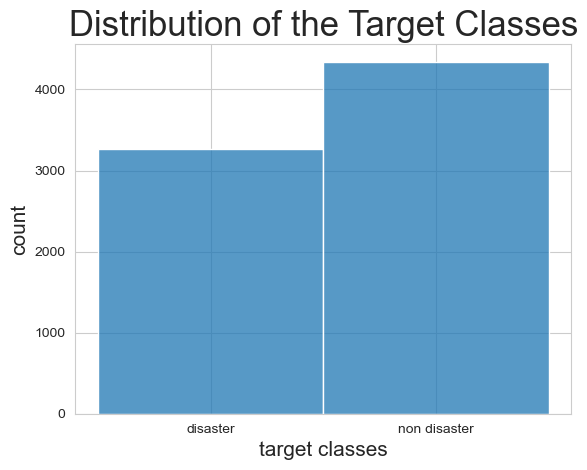

In [10]:
# Review Target Classes Distribution
disaster_rate = {1:'disaster',0:'non disaster'}
data_train['label_names'] = data_train['labels'].map(disaster_rate)

sns.histplot(data=data_train.label_names)

plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)

There is a minor class imbalance present in the training dataset, which could potentially pose an issue.

In [11]:
# Display the characteristics of keyword values
# Train data
print(f'Number of unique keyword values: {data_train.keyword.nunique()}')
print(f'Total Number of keywords: {data_train[~data_train.keyword.isnull()].keyword.count()}')
print(f'Ratio = {data_train.keyword.nunique()/data_train[~data_train.keyword.isnull()].keyword.count():.2f}')

Number of unique keyword values: 221
Total Number of keywords: 7552
Ratio = 0.03


In [12]:
# Test data
print(f'Number of unique keyword values: {data_test.keyword.nunique()}')
print(f'Total Number of keywords: {data_test[~data_test.keyword.isnull()].keyword.count()}')
print(f'Ratio = {data_test.keyword.nunique()/data_test[~data_test.keyword.isnull()].keyword.count():.2f}')

Number of unique keyword values: 221
Total Number of keywords: 3237
Ratio = 0.07


[Text(0.5, 1.0, 'Top 20 Keywords in the Train Dataset')]

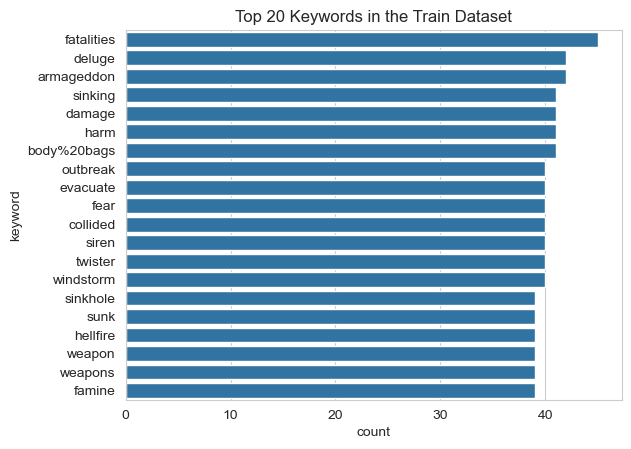

In [13]:
# Display Top 20 keywords in both train and test datasets.
####################################
top20_keywords_train = data_train.groupby('keyword')['keyword'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)
####################################
sns.barplot(data=top20_keywords_train,x='count',y='keyword').set(title='Top 20 Keywords in the Train Dataset')

[Text(0.5, 1.0, 'Top 20 Keywords in the Test Dataset')]

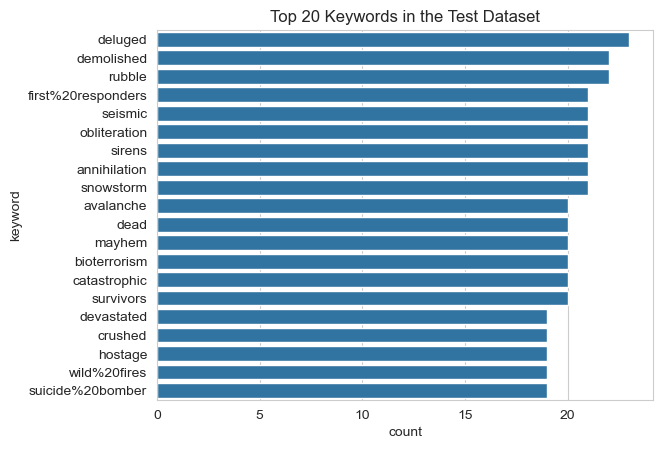

In [14]:
####################################
top20_keywords_test = data_test.groupby('keyword')['keyword'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)
####################################
sns.barplot(data=top20_keywords_test,x='count',y='keyword').set(title='Top 20 Keywords in the Test Dataset')

[Text(0.5, 1.0, 'Top 20 Locations in the Train Dataset')]

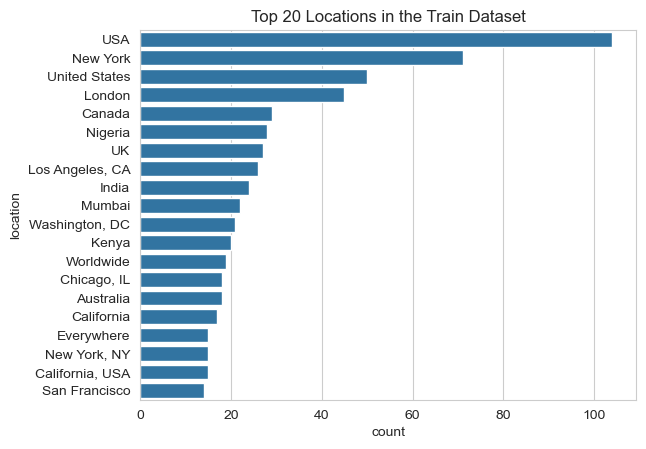

In [15]:
# Display Top 20 Locations in both train and test datasets.
####################################
top20_locations_train = data_train.groupby('location')['location'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)
####################################
sns.barplot(data=top20_locations_train,x='count',y='location').set(title='Top 20 Locations in the Train Dataset')

[Text(0.5, 1.0, 'Top 20 Locations in the Test Dataset')]

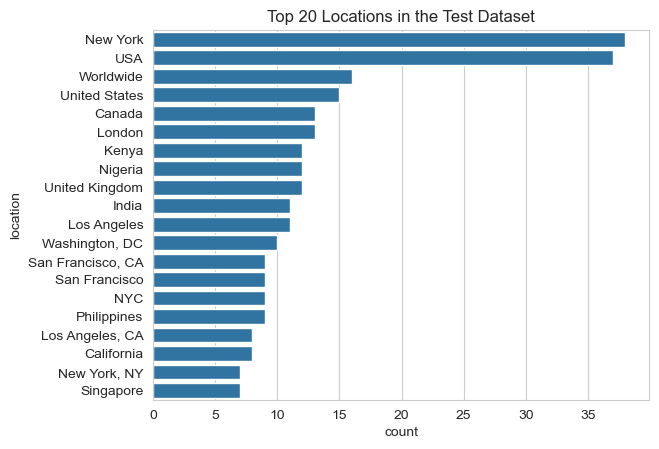

In [16]:
####################################
top20_locations_test = data_test.groupby('location')['location'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(20)
####################################
sns.barplot(data=top20_locations_test,x='count',y='location').set(title='Top 20 Locations in the Test Dataset')

In [17]:
# Review number of unique values in the text column
data_train['text'].nunique(), len(data_train)

(7503, 7613)

[Text(0.5, 1.0, 'Disaster Tweets Word Count Distribution')]

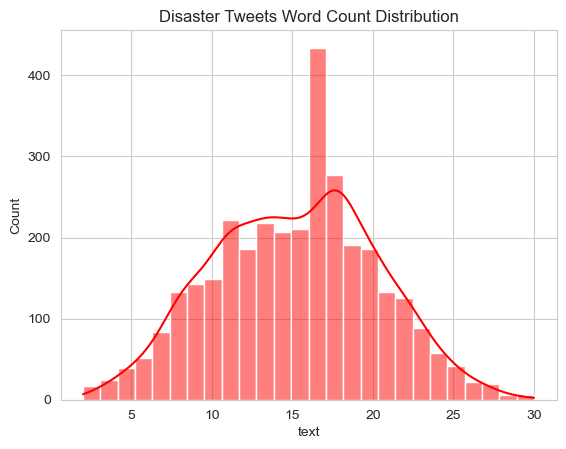

In [18]:
#######################
num_words_dis = data_train[data_train['labels']==1]['text'].str.split().map(lambda x: len(x))
#######################
sns.histplot(num_words_dis,color='red',label='disaster',kde=True).set(title='Disaster Tweets Word Count Distribution')

[Text(0.5, 1.0, 'Non Disaster Tweets Word Count Distribution')]

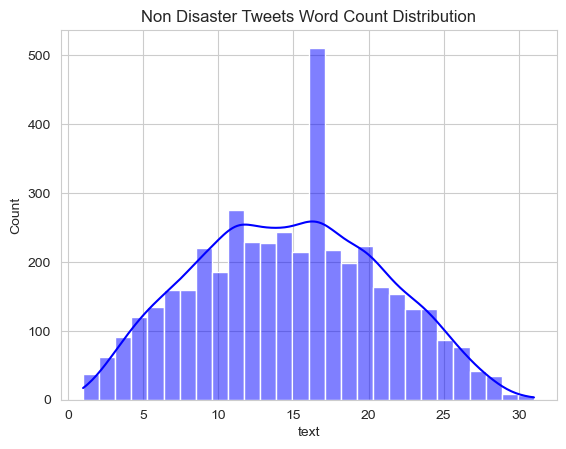

In [19]:
#######################
num_words_ndis = data_train[data_train['labels']==0]['text'].str.split().map(lambda x: len(x))
#######################
sns.histplot(num_words_ndis,color='blue',label='non disaster',kde=True).set(title='Non Disaster Tweets Word Count Distribution')

In [20]:
# Review the statistics of the number of words in the text column
num_words_dis.describe(), num_words_ndis.describe()

(count    3271.000000
 mean       15.167533
 std         5.096806
 min         2.000000
 25%        11.000000
 50%        15.000000
 75%        19.000000
 max        30.000000
 Name: text, dtype: float64,
 count    4342.000000
 mean       14.704744
 std         6.161564
 min         1.000000
 25%        10.000000
 50%        15.000000
 75%        19.000000
 max        31.000000
 Name: text, dtype: float64)

[Text(0.5, 1.0, 'Disaster Tweets Average Word Length Distribution')]

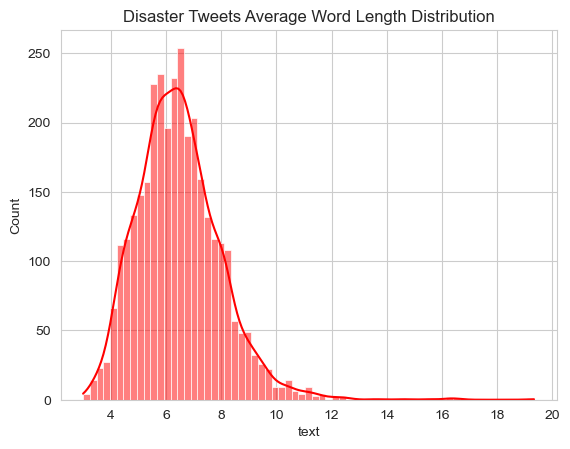

In [21]:
########################
char_len_dis = data_train[data_train['labels']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
########################
sns.histplot(char_len_dis.map(lambda x: np.mean(x)),color='red',label='disaster',kde=True).set(title='Disaster Tweets Average Word Length Distribution')

[Text(0.5, 1.0, 'Non Disaster Tweets Average Word Length Distribution')]

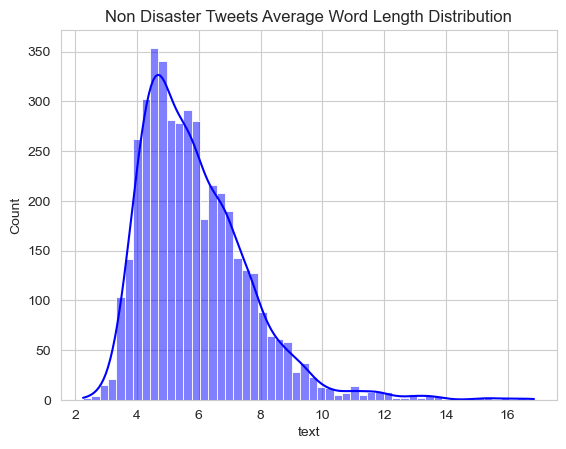

In [22]:
########################
char_len_ndis = data_train[data_train['labels']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
########################
sns.histplot(char_len_ndis.map(lambda x: np.mean(x)),color='blue',label='non disaster',kde=True).set(title='Non Disaster Tweets Average Word Length Distribution')

In [23]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.1 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [24]:
nlp = spacy.load("en_core_web_sm")

In [25]:
def clean_string(text, stem="Spacy"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    # Note: that this line can be augmented and used over
    # to replace any characters with nothing or a space
    text = re.sub(r'\n', '', text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer()
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [26]:
# Before cleaning
data_train.head()

,id,keyword,location,text,labels,label_names
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,disaster
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,non disaster
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,disaster
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,non disaster
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,non disaster


In [27]:
data_train['text'] = data_train['text'].apply(clean_string)

In [28]:
# After cleaning
data_train.head()

,id,keyword,location,text,labels,label_names
2644,3796,destruction,NaN,new weapon cause unimaginable destruction,1,disaster
2227,3185,deluge,NaN,fampe thing gishwhe get soak deluge go pad tam...,0,non disaster
5448,7769,police,UK,dt georgegalloway rt ûïthe col police catch...,1,disaster
132,191,aftershock,NaN,aftershock back school kick great want thank e...,0,non disaster
6845,9810,trauma,"Montgomery County, MD",response trauma child addict develop defensive...,0,non disaster


[Text(0.5, 1.0, 'Most Common Words in Tweets')]

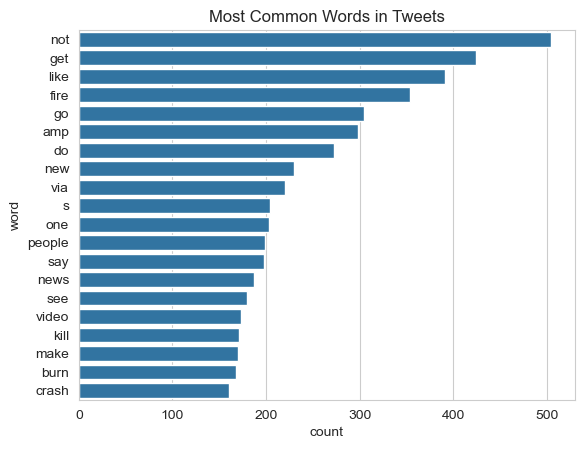

In [29]:
# Most common words in tweets
num_words = Counter(" ".join(data_train["text"]).split()).most_common(20)
# Convert a list of tuples to a DataFrame
num_words_df = pd.DataFrame(num_words, columns=['word', 'count'])
# Plot the most common words
sns.barplot(data=num_words_df, x='count', y='word').set(title='Most Common Words in Tweets')

[Text(0.5, 1.0, 'Most Common Words in Disaster Tweets')]

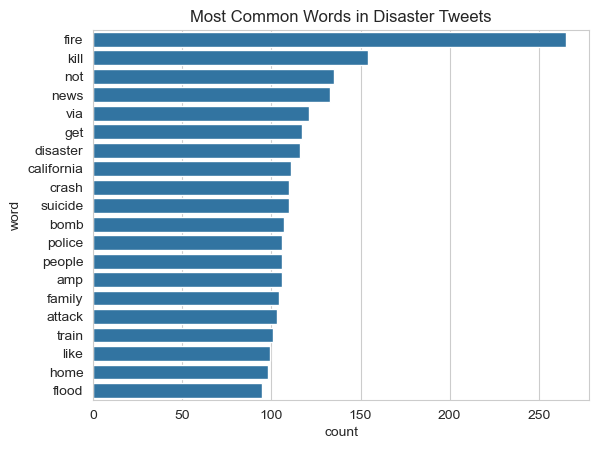

In [30]:
#######################
data_disaster = data_train[data_train['labels'] == 1]
data_nondisaster = data_train[data_train['labels'] == 0]

num_words_disaster = Counter(" ".join(data_disaster["text"]).split()).most_common(20)
num_words_nondisaster = Counter(" ".join(data_nondisaster["text"]).split()).most_common(20)
#######################
# Convert a list of tuples to a DataFrame
num_words_disaster_df = pd.DataFrame(num_words_disaster, columns=['word', 'count'])
num_words_nondisaster_df = pd.DataFrame(num_words_nondisaster, columns=['word', 'count'])
# Plot the most common words in disaster tweets
sns.barplot(data=num_words_disaster_df, x='count', y='word').set(title='Most Common Words in Disaster Tweets')

[Text(0.5, 1.0, 'Most Common Words in Non-Disaster Tweets')]

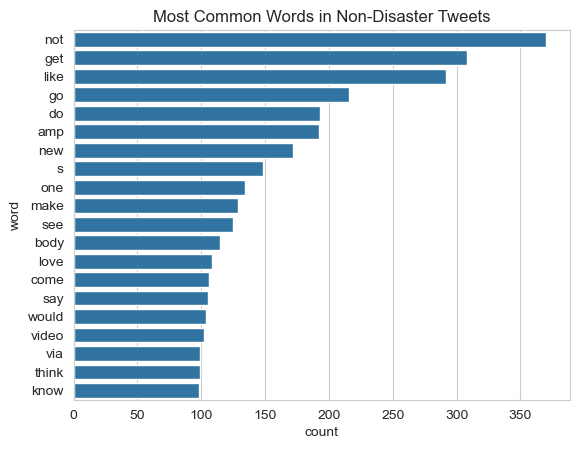

In [31]:
# Plot the most common words in non-disaster tweets
sns.barplot(data=num_words_nondisaster_df, x='count', y='word').set(title='Most Common Words in Non-Disaster Tweets')

In [32]:
# Word cloud for disaster and non-disaster tweets
text_dis  = ' '.join(data_disaster['text'])
text_ndis = ' '.join(data_nondisaster['text'])

wordcloud_dis  = WordCloud().generate(text_dis)
wordcloud_ndis = WordCloud().generate(text_ndis)

(-0.5, 399.5, 199.5, -0.5)

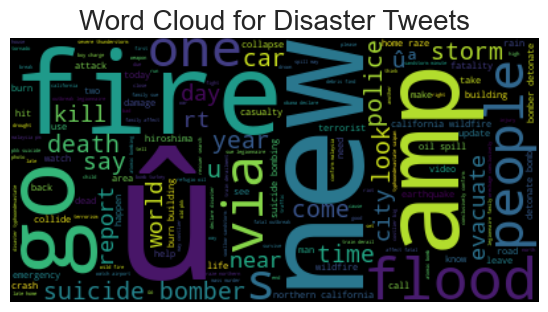

In [33]:
# Generate the word clouds for disaster tweets
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_dis, interpolation='bilinear')
plt.title('Word Cloud for Disaster Tweets', fontsize=20)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

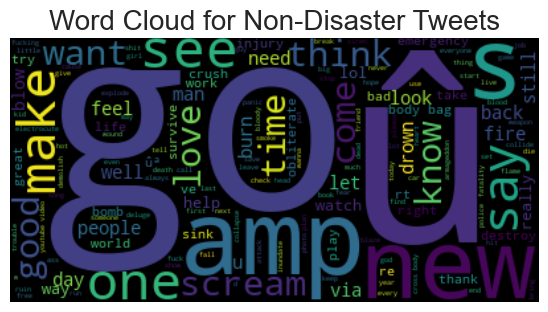

In [34]:
# Generate the word clouds for non-disaster tweets
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ndis, interpolation='bilinear')
plt.title('Word Cloud for Non-Disaster Tweets', fontsize=20)
plt.axis('off')

Model Architecture

In [49]:
# Prepare the data for training
data_train_cp = data_train.copy()
data_test_cp  = data_test.copy()

train_id = data_train_cp["id"]
test_id  = data_test_cp["id"]

#data_train3.drop(['keyword','location','id','label'],axis=1,inplace=True)
data_train_cp.drop(['keyword','location','id'],axis=1,inplace=True)
data_test_cp.drop(['keyword','location','id'],axis=1,inplace=True)

data_train_cp.head()

,text,labels,label_names
2644,new weapon cause unimaginable destruction,1,disaster
2227,fampe thing gishwhe get soak deluge go pad tam...,0,non disaster
5448,dt georgegalloway rt ûïthe col police catch...,1,disaster
132,aftershock back school kick great want thank e...,0,non disaster
6845,response trauma child addict develop defensive...,0,non disaster


In [50]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [51]:
# Tokenize the text data
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(data_train_cp["text"])
test_vectors = count_vectorizer.transform(data_test_cp["text"])

In [52]:
clf = linear_model.RidgeClassifier()

In [74]:
scores = model_selection.cross_val_score(clf, train_vectors, data_train_cp["labels"], cv=2, scoring="f1")
scores

array([0.70837406, 0.71762768])

In [55]:
clf.fit(train_vectors, data_train_cp["labels"])

RidgeClassifier()

In [61]:
sample_submission = pd.read_csv("./data/sample_submission.csv")
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0


In [64]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = data_train_cp.text
y = data_train_cp.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.fit_transform(X_train)
print(type(X_train_dtm), X_train_dtm.shape)
X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (5709, 12569)
<class 'scipy.sparse._csr.csr_matrix'> (1904, 12569)


In [66]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50323 stored elements and shape (5709, 12569)>

In [67]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

CPU times: user 1.78 ms, sys: 106 μs, total: 1.89 ms
Wall time: 2.98 ms


MultinomialNB()

In [71]:
from sklearn import metrics

y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred_class))

# calculate F1 score
print("=======F1 Score===========")
print(metrics.f1_score(y_test, y_pred_class))

=======Accuracy Score===========
0.8035714285714286
=======Confision Matrix===========
[[928 148]
 [226 602]]
=======F1 Score===========
0.7629911280101395


Results and Conclusion

The author has successfully developed a machine-learning model to distinguish between Tweets that discuss natural disasters and those that do not. The model achieved an accuracy score of 0.79 and an F1 score of 0.71. The model was trained using the Ridge Classifier and the CountVectorizer. The author also trained a Multinomial Naive Bayes model using the CountVectorizer and achieved an accuracy score of 0.79 and an F1 score of 0.71. The author recommends further exploration of the data and the use of more advanced models to improve the performance of the model.